# ClimateNet AR/TC Analysis: Global Frequency Maps

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl

In [7]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem = '5GB' # specify memory here so it duplicates below
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})
# the above is for jupyterhub only, otherwise use /proxy/{port}/status (also need to launch ssh tunneling from the appropriate environment)
#dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"})
# really I should set these options in some sort of config file...

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39152 instead
  warnings.warn(
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, b

In [8]:
client

<Client: 'tcp://10.12.206.48:37574' processes=10 threads=10, memory=46.60 GiB>

## Analysis notes
- replace `.where` with `.clip` if possible for speed

## Set ClimateNet filepath

In [9]:
#cesm_cnet_filepath = "/glade/campaign/cgd/amp/jet/ClimateNet/" # pretrained LBL model, 2000-2005
#cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, 2000-2006, before means/std bug fix
cesm_cnet_filepath = "/glade/p/cgd/ccr/people/tking/cgnet_masks/" # retrained NCAR model, 2000-2015, after means/std bug fix
#cesm_cnet_filepath = "/glade/scratch/tking/" # testing TMQ-only config file

In [25]:
#cesm_cnet_folders = ["output.cgnet.2000/", "output.cgnet.2001/", "output.cgnet.2002/", "output.cgnet.2003/", "output.cgnet.2004/", "output.cgnet.2005/"] # pretrained LBL model, 2000-2005
#cesm_cnet_folders = ["results.2000/", "results.2001/", "results.2002/", "results.2003/", "results.2004/", "results.2005/"] # retrained NCAR model, 2000-2006, before means/std bug fix
#cesm_cnet_folders = ["results.2000/"] # year 2000 only
#cesm_cnet_folders = ["tmq_psl_v850_u850/"] # retrained NCAR model, 2000-2015, after means/std bug fix
cesm_cnet_folders = ["tmq_v850/actual_tmq_v850_masks/"] # after config file bug fix
#cesm_cnet_folders = ["tmq_only/actual_tmq_only_masks/"] # after config file bug fix

### CESM historical simulation

In [26]:
#cnet_files = "b.e13.B20TRC5CN.ne120_g16.003*.nc" # pretrained LBL model
cnet_files = "class_masks*.nc" # retrained NCAR model
#cnet_files = "class_masks.200[0-5]*" # testing years 2000-2005

In [ ]:
# start with year 2000 only to solidfy workflow
#cnet_2000 = xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folders[0]+cnet_files, concat_dim='time', combine="nested", chunks={'time':360}, parallel=True) # aim for chunk size < 100mb
#cnet_2000

In [27]:
%%time
# read in all the masks
# adjust chunks for length of timeseries data
cnet = [xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True) for i,f in enumerate(cesm_cnet_folders)]
# concat across time
cnet_concat = xr.concat(cnet,dim='time')

CPU times: user 422 ms, sys: 28.9 ms, total: 451 ms
Wall time: 857 ms


In [28]:
cnet_concat

<xarray.Dataset>
Dimensions:                        (lon: 1152, lat: 768, time: 46720)
Coordinates:
  * lon                            (lon) float64 0.0 0.3125 ... 359.4 359.7
  * lat                            (lat) float64 -90.0 -89.77 ... 89.77 90.0
  * time                           (time) object 2000-01-01 03:00:00 ... 2015...
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) int64 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>

In [29]:
#cnet_mask = cnet_concat.output_tag # pretrained LBL model
cnet_mask = cnet_concat.__xarray_dataarray_variable__.rename("output_tag") # retrained NCAR model; rename data variable
cnet_mask

<xarray.DataArray 'output_tag' (time: 46720, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(46720, 768, 1152), dtype=int64, chunksize=(50, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 1.9.9 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    np:                         4
    ne:                         120
    case:                       b.e13.B20TRC5CN.ne120_g16.003
    ...                         ...
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             casper19
    remap_version:              4.7.9
    map_file:                   /glade/work/nanr/mapfiles/map_ne120_to_0.23x0...
    input_file:                 ./b.e13.B20TRC5CN.ne120_g16.003.cam.h3.PSL.20...
    CDO:                        Climate Data Operators version 1.9.9 (https:/...

### Static plot for visualization

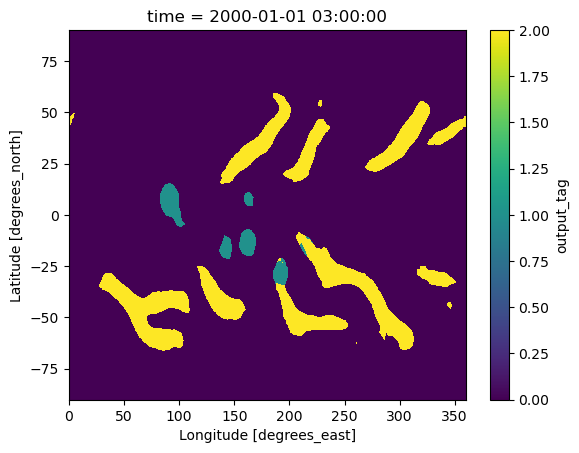

In [30]:
cnet_mask.isel(time=0).plot();

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

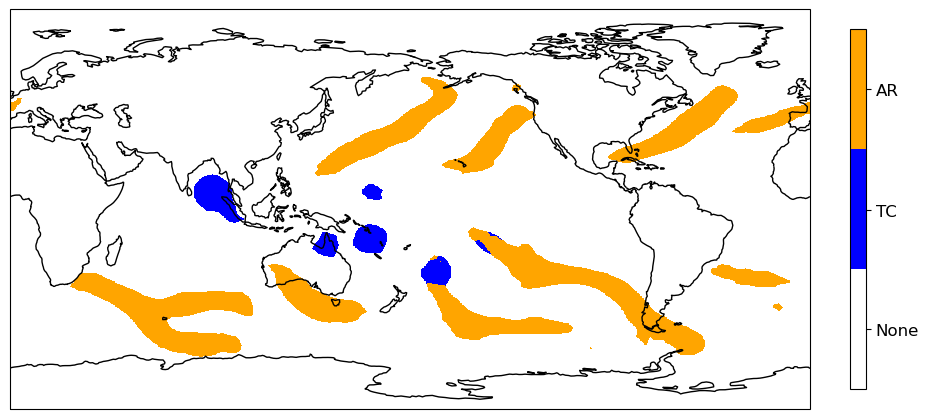

In [31]:
cmap_all = mcolors.ListedColormap(['w', 'blue', 'orange'])
bounds = [0, 0.99, 1.99, 2.99]
#norm = mcolors.BoundaryNorm(bounds, cmap_all.N)

fig = plt.figure(figsize=(8,6))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0)) # shift map center to highlight Pacific

lat = cnet_mask.lat
lon = cnet_mask.lon
#cf = ax.contourf(lon, lat, cnet_mask.isel(time=0), cmap=cmap_all, vmin=0, vmax=2.99, levels=bounds, transform=ccrs.PlateCarree())
pc = ax.pcolormesh(lon, lat, cnet_mask.isel(time=0), cmap=cmap_all, vmin=0, vmax=2.99, transform=ccrs.PlateCarree()) # get rid of edge colors

ax.coastlines()

cbar_ax = fig.add_axes([1.05, 0.2, 0.02, 0.6])
norm = mpl.colors.Normalize(vmin=0, vmax=2.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99])
loc    = labels + .5
tick_1 = ['None','TC','AR']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

#plt.savefig('../figures/toSCP/CGnet_time=0_beforebugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_afterbugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_tmq-v850.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_tmq-only.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_tmq-v850_configfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_tmq-only_configfix.png', bbox_inches='tight')

### Global AR frequency maps
See Lora et al. 2020 for comparison

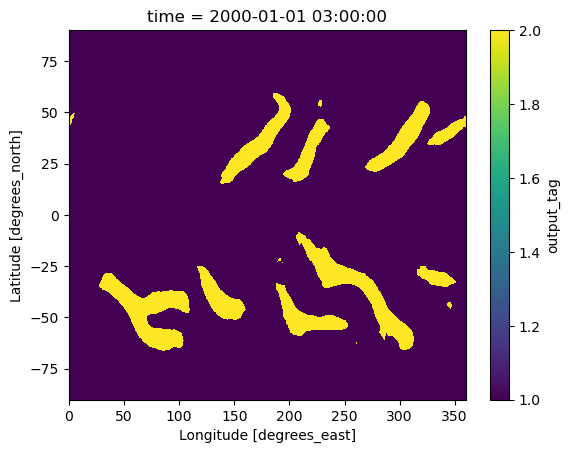

In [32]:
# TCs are still here, but now everything not AR has been set to 1
cnet_mask.clip(min=1).isel(time=0).plot();

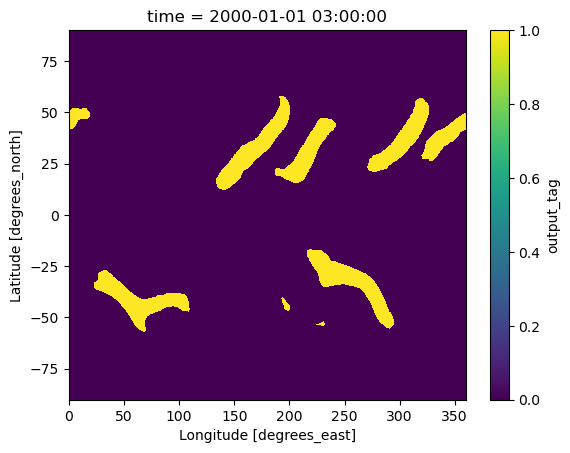

In [20]:
# method to select only ARs (value=2)
# clip is so much faster than where but it doesn't create a masked array
(cnet_mask.clip(min=1).isel(time=0)-1).plot(); # in absense of masked array, need to subtract 1 to get ARs = 1 and everything else = 0

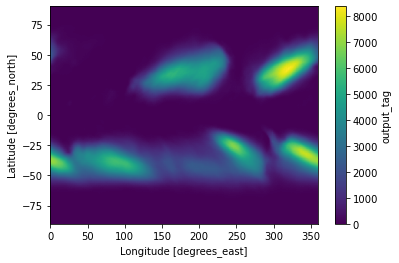

In [28]:
# sum at each gridpoint over time
(cnet_mask.clip(min=1)-1).sum(dim='time').plot()

In [29]:
len(cnet_mask.time)

17520

In [33]:
npercentARs = 100*((cnet_mask.clip(min=1)-1).sum(dim='time'))/len(cnet_mask.time)
#npercentARs.plot(robust=True);

In [34]:
npercentARs = npercentARs.persist()

In [35]:
npercentARs.max().values

array(50.63998288)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

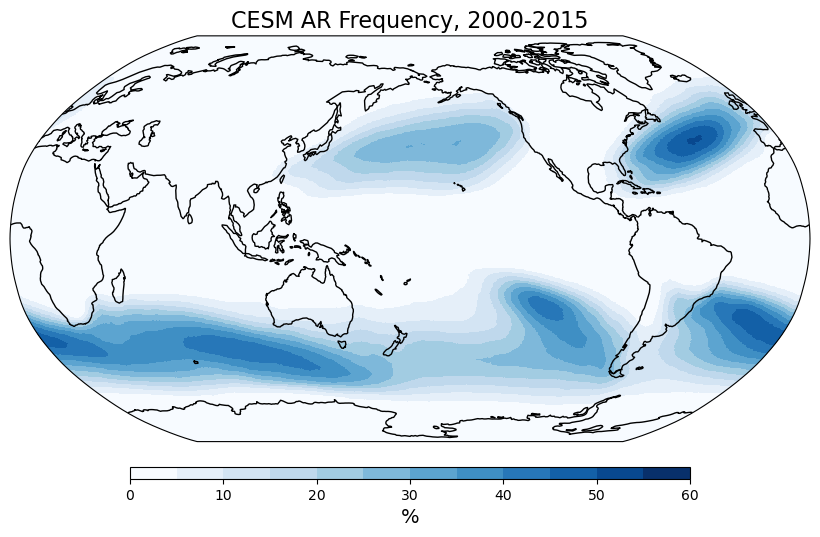

In [36]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)
vmax=60

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs.lat
lon = npercentARs.lon
pc = ax.pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#ax.set_title('CESM AR Frequency, 2000-2005', fontsize=16); 
ax.set_title('CESM AR Frequency, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_beforebugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_afterbugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_tmq-v850.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_tmq-only.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_tmq-v850_configfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_tmq-only_configfix.png', bbox_inches='tight')

### Global TC frequency masks
Note: release the ``npercentARs`` variable from memory so the ``npercentTCs`` processing doesn't run out of memory (or increase the dask request)

In [37]:
del npercentARs

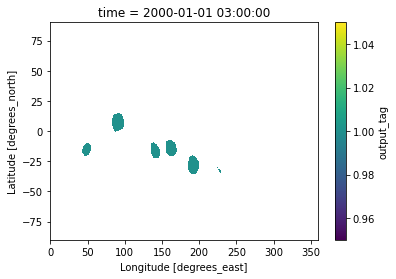

In [29]:
# can't figure out how to use .clip to select TCs
(cnet_mask.where(cnet_mask==1).isel(time=0)).plot() 

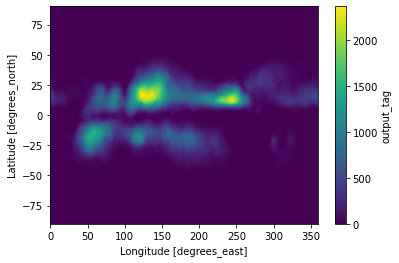

In [32]:
cnet_mask.where(cnet_mask==1).sum(dim='time').plot()

In [33]:
len(cnet_mask.time)

17520

In [38]:
# can't figure out how to use .clip to select TCs
npercentTCs = 100*(cnet_mask.where(cnet_mask==1).sum(dim='time'))/len(cnet_mask.time)

In [78]:
npercentTCs

<xarray.DataArray 'output_tag' (lat: 768, lon: 1152)>
dask.array<truediv, shape=(768, 1152), dtype=float64, chunksize=(768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7

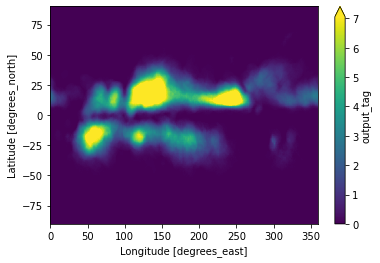

In [ ]:
npercentTCs.plot(robust=True);

In [39]:
npercentTCs = npercentTCs.persist()

In [40]:
npercentTCs.max().values

array(15.83261986)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

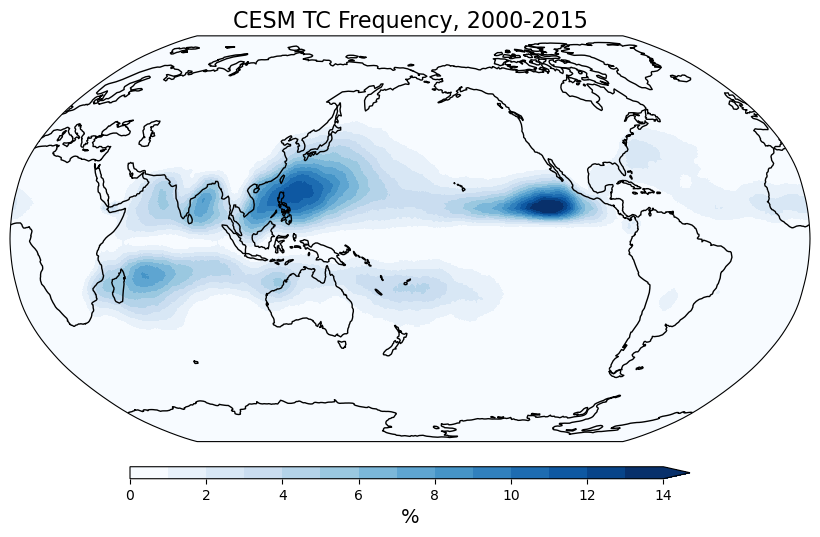

In [41]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 14)
vmax=14

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentTCs.lat
lon = npercentTCs.lon
pc = ax.pcolormesh(lon, lat, npercentTCs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#ax.set_title('CESM TC Frequency, 2000-2005', fontsize=16); 
ax.set_title('CESM TC Frequency, 2000-2015', fontsize=16);

#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_beforebugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_afterbugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-v850.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-only.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-v850_configfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-only_configfix.png', bbox_inches='tight')

### Close cluster/client as needed

In [42]:
client.close()
cluster.close()

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
